# Computations for Out(RAAGs)

This notebook contains some functions that can be used to perform calculations for automorphism groups of RAAGs. In particular, these allow to compute the Laurence-Servatius generators of Out<sup>0</sup>(A<sub>Γ</sub>), calculate invariant special subgroups, check whether two vertices form a SIL pair etc. Most functions work in the setting of the relative versions of these automorphism groups as defined by [Day-Wade](https://doi.org/10.1112/topo.12101).

This was used for generating the two examples of RAAGs whose outer automorphism group is not a virtual duality group given in the appendix of [A note on virtual duality and automorphism groups of right-angled Artin groups](https://arxiv.org/abs/2101.08225), arxiv 2101.08225. I also used some of the functions for finding examples and generating/ falsifying conjectures during the work on my [PhD thesis](https://pub.uni-bielefeld.de/record/2940020). 

The functions defined below are quite primitive and the runtime is not optimised at all. Basically all of them just naively follow the same steps that one would do when performing the calculations by hand. In particular, this leads to many loops that take comparably much time in python.

Parts of this code were also used and extended by Manuel Wiedmer [in this repository](https://github.com/manuelwiedmer/RAAGs-as-subgroups-of-Out-RAAGs-).

## Preliminary definitions

Import packages needed for the calculations:

In [1]:
import networkx as nx
import itertools as it
import copy
import matplotlib.pyplot as plt
import random
import sys

Some general basic functions:

In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(0, len(s)+1))

def listOfProperSubsets(iterable):
    "listOfProperSubsets([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(1, len(s)))
    
def progressBar(name, value, endvalue, bar_length = 25, width = 20):
    """
    Displays a progress bar with "name", tracking the progess of value/endvalue.
    """
    
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent*bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r{0: <{1}} : [{2}]{3}%".format(name, width, arrow + spaces, int(round(percent*100))))
    sys.stdout.flush()
    if value == endvalue:
         sys.stdout.write('\n\n')

In what follows, all graphs are, if not mentioned otherwise, assumed to be undirected simple "Graph" networkx-objects. Such an object can e.g. be created as follows:

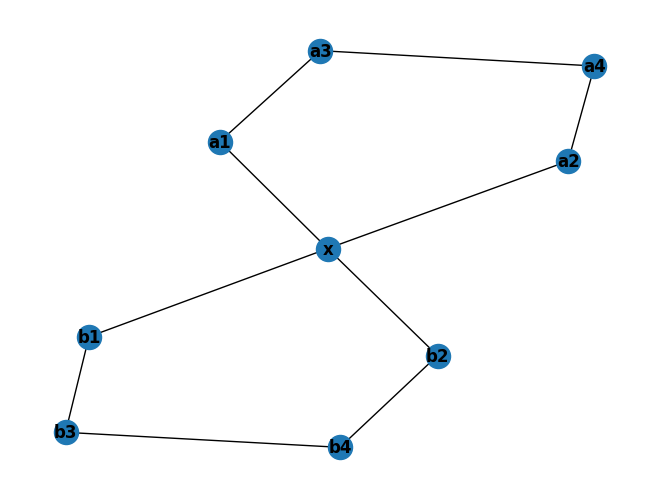

In [3]:
Gamma = nx.Graph()
Gamma.add_nodes_from(["a1","a2","a3","a4","b1","b2","b3","b4","x"])
Gamma.add_edges_from([("a1","a3"),("a3","a4"),("a4","a2"),("a1","x"),("a2","x"),("b1","b3"),("b3","b4"),("b4","b2"),("b1","x"),("b2","x")])
nx.draw(Gamma, with_labels=True, font_weight='bold')

## Functions for (relative) automorphism groups of RAAGs

Some basic functions for working with Out(RAAGs) and relative version of them. For the definitions, see Day-Wade: Relative automorphism groups of right-angled Artin groups [arxiv 1712.01583](https://arxiv.org/abs/1712.01583) or my [PhD thesis](https://pub.uni-bielefeld.de/record/2940020).

In [4]:
def star(vertex,Graph):
    """Returns the star of vertex in Graph.
    
    Graph : a networkx graph
    vertex : a vertex of Graph
    """
    
    st = set(Graph[vertex])|{vertex}
    return st

def conn_comps(Gamma,v):
    """Lists the connected components of Gamma\st(v).
    
    Gamma : a networkx graph
    v : a vertex of Gamma
    """
    
    Gamma_without_st = copy.deepcopy(Gamma)
    Gamma_without_st.remove_nodes_from(star(v,Gamma))
    return list(nx.connected_components(Gamma_without_st))

def upwardsClosed(Order,Subset):
    """Returns True if Subset is an upwards closed subset of the partial order Order and False if not.
    
    Order : a DiGraph in networkx
    Subset : a subset of the vertices of Order
    """
    
    for x in Subset:
        if not set(Order[x]).issubset(Subset):
            return False
    return True

def gorder(Graph,setofSubgraphs):
    """Determines the order of the vertices of Graph with respect to (mcG=)setofSubgraphs.
    
    Graph : a networkx graph
    setofSubgraphs : a collection of subsets of the vertex set of Graph    
    
    For setofSubgraphs=set(), one recovers the standard order of the vertices.
    """

    O=nx.DiGraph()
    O.add_nodes_from(Graph)
    for n in Graph.nodes:
        for m in Graph.nodes:
            edge = True
            if  not m==n and set(Graph[n]).issubset(star(m,Graph)):
                for Subgraph in setofSubgraphs:
                    if n in Subgraph:
                        if not m in Subgraph:
                            edge = False
                            break
                if edge:
                    O.add_edge(n,m)
    return O

def inversions(Gamma,mcG,mcH):
    """Returns the list of inversions contained in Out^0(A_Gamma,mcG,mcH^t).
    
    Gamma :  a networkx graph
    mcG : a collection of subsets of the vertex set of Gamma 
    mcH : a collection of subsets of the vertex set of Gamma     
    """

    inv=set(Gamma)
    for x in mcH:
        inv=inv.difference(x)
    return list(inv)

def transvections(Gamma,mcG,mcH):
    """Returns the list of transvections contained in Out^0(A_Gamma,mcG,mcH^t).
    
    Gamma :  a networkx graph
    mcG : a collection of subsets of the vertex set of Gamma 
    mcH : a collection of subsets of the vertex set of Gamma     
    """

    Gset=set()
    for x in mcG:
        Gset.add(frozenset(x))
    # make sure that mcG contains P(H):
    for Delta in mcH:
        Gset=Gset.union(frozenset(powerset(Delta)))
    mcG=list(Gset)
    tv=list(gorder(Gamma,mcG).edges)
    return tv

def partialConjugations(Gamma,mcG,mcH):
    """Returns the list of partial conjugations contained in Out^0(A_Gamma,mcG,mcH^t).
    
    Gamma :  a networkx graph
    mcG : a collection of subsets of the vertex set of Gamma 
    mcH : a collection of subsets of the vertex set of Gamma     
    """

    pc=[]
    Gset=set()
    for x in mcG:
        Gset.add(frozenset(x))
    #make sure that mcG contains the powerset P(H):
    for Delta in mcH:
        Gset=Gset.union(frozenset(powerset(Delta)))
    mcG=list(Gset)
    for x in Gamma:
        starx=star(x,Gamma)
        if not len(starx)==len(Gamma.nodes):
            Gammax = copy.deepcopy(Gamma)
            for Delta in mcG:
                if x not in Delta:
                    Gammax=nx.compose(nx.complete_graph(Delta),Gammax)
            Gammax.remove_nodes_from(starx)
            if not nx.is_connected(Gammax):
                for comp in nx.connected_components(Gammax):
                    pc.append([x,comp])
    return pc

def pc(Gamma,v):
    """Lists the partial conjugations in Out(A_Gamma) with multiplying letter v.
    
    Gamma : a networkx graph
    v : a vertex of Gamma
    """ 
    
    listpc = []
    for x in partialConjugations(Gamma,{},{}):
        if x[0]==v:
            listpc.append(x)
    return listpc

Further functions for working with relative automorphism groups of RAAGs. These are not needed for checking duality. 

In [5]:
def starSeparated(Graph,setofSubgraphs,Delta2):
    """Returns True if Delta2 is starSeparated by an outside vertex in Gamma with respect to the adjacency relation 
    determined by the list of special subgroups setofSubgraphs and False if not.
    
    Graph : a networkx graph
    setofSubgraphs : a collection of subsets of the vertex set of Graph
    Delta2 : a subset of the vertex set of Graph
    """

    for x in set(Graph).difference(Delta2):
        starx=star(x,Graph)
        if not len(starx)==len(Graph.nodes):
            Gammax = copy.deepcopy(Graph)
            for Delta in setofSubgraphs:
                if x not in Delta:
                    Gammax=nx.compose(nx.complete_graph(Delta),Gammax)
            Gammax.remove_nodes_from(starx)
            deltainstardel = set(Gammax).intersection(set(Delta2))
            if deltainstardel and not deltainstardel.issubset(set(nx.node_connected_component(Gammax, list(deltainstardel)[0]))):
                return True
    return False
    
def saturation(Gamma,mcG,mcH):
    """Returns a list of all subgraphs of Gamma that are stabilised by Out^0(A_Gamma,mcG,mcH^t).
    
    Gamma :  a networkx graph
    mcG : a collection of subsets of the vertex set of Gamma 
    mcH : a collection of subsets of the vertex set of Gamma 
    """

    Gset=set()
    sat=[]
    for x in mcG:
        Gset.add(frozenset(x))
    #make sure that mcG contains the powerset P(mcH):
    for Delta in mcH:
        Gset=Gset.union(frozenset(powerset(Delta)))
    mcG=list(Gset)
    standardorder=gorder(Gamma,mcG)
    for Delta in listOfProperSubsets(Gamma.nodes):
        if upwardsClosed(standardorder,Delta) and not starSeparated(Gamma,mcG,Delta):
            sat.append(Delta)
    return sat

As explained in Day-Wade: Subspace arrangements, BNS invariants, and pure symmetric outer automorphisms of right-angled Artin groups [arxiv 1508.00622](https://arxiv.org/abs/1508.00622), there are cases where PSO(A<sub>Γ</sub>) is isomorphic to a RAAG A<sub>Θ</sub>.The following functions are used to check whether this is the case and if so, compute the defining graph Θ.

In [6]:
def is_Sil(Gamma,a,b):
    """Checks whether a and b form a SIL pair in the graph Gamma.
    
    Gamma : a networkx graph
    a : a vertex of Gamma
    b : a vertex of Gamma
    """

    for x in Gamma.neighbors(a):
        # first check whether they are adjacent
        if x==b:
            return False
    for comp1 in conn_comps(Gamma,a):
        for comp2 in conn_comps(Gamma,b):
            if comp1 == comp2:
                return True
    return False

def supp_graph(Gamma,vertex):
    """Returns the support graph of vertex.
    
    Gamma : a networkx graph
    vertex : a vertex of Gamma
    """

    suppgraph = nx.Graph()
    node = 0

    for comp in conn_comps(Gamma, vertex):
        suppgraph.add_node(node, vertices = comp)
        node = node + 1

    for n in suppgraph.nodes():
        for m in suppgraph.nodes():
            if n != m:
                for x in suppgraph.nodes[m]["vertices"]:
                    for comp in conn_comps(Gamma,x):
                        if suppgraph.nodes[n]["vertices"]==comp:
                            suppgraph.add_edge(n,m)
    
    return(suppgraph)

def theta(Gamma):
    """Returns theta, the defining graph for the RAAG structure of PSO(A_Gamma) 
    
    Gamma : a networkx graph
    
    ATTENTION: To save time, it only computes the parts of theta that are relevant for checking whether the associated
    flag complex is Cohen-Macaulay. That is, it does not include the generators v_C^a as those are connected to every 
    other vertex of theta anyway.
    """

    theta = nx.Graph()
    node = 0
    for v in Gamma.nodes:
        sg = supp_graph(Gamma,v)
        if len(sg.edges) > 0:
            for supp_edge in sg.edges:
                supp_edge_start = supp_edge[0]
                supp_edge_end = supp_edge[1]
                theta.add_node(node,comp = [v,sg.nodes[supp_edge_start]["vertices"],sg.nodes[supp_edge_end]["vertices"]])
                node = node + 1
    for x in theta.nodes:
        for y in theta.nodes:
            added_edge = False
            if x !=y:
                if not is_Sil(Gamma,theta.nodes[x]["comp"][0],theta.nodes[y]["comp"][0]):
                    theta.add_edge(x,y)
                else:
                    if theta.nodes[x]["comp"][0] in theta.nodes[y]["comp"][1]:
                        non_dominant_comp1 = theta.nodes[y]["comp"][2]
                    elif theta.nodes[x]["comp"][0] in theta.nodes[y]["comp"][2]:
                        non_dominant_comp1 = theta.nodes[y]["comp"][1]
                    else:
                        theta.add_edge(x,y)
                        added_edge = True
                    if not added_edge:
                        if theta.nodes[y]["comp"][0] in theta.nodes[x]["comp"][1]:
                            non_dominant_comp2 = theta.nodes[x]["comp"][2]
                        elif theta.nodes[y]["comp"][0] in theta.nodes[x]["comp"][2]:
                            non_dominant_comp2 = theta.nodes[x]["comp"][1]
                        else:
                            theta.add_edge(x,y)
                            added_edge = True
                    if not added_edge:
                        #If the code arrives here, the pairs contain dominant components for one another.
                        if non_dominant_comp1 != non_dominant_comp2:
                            #other components do not coincide:
                            theta.add_edge(x,y)
    return theta

## Cohen-Macaulay complexes
The following functions give obstructions for the flag complex of a graph Gamma to be Cohen-Macaulay.

In [7]:
def all_cliques_same_size(Gamma):
    """Checks whether all cliques in Gamma have the same size. Returns True if they do and False otherwise. 
    
    Gamma : a networkx graph
    
    This is equivalent to the flag complex being pure, a necessary condition for Cohen-Macaulayness.
    """

    if len(thet.edges())>0:
        #without this condition, it's definitely not interesting
        max_cliques = nx.find_cliques(Gamma)
        cliquesize = len(next(max_cliques))
        for x in max_cliques:
            if len(x)!=cliquesize:
                return False
    return True

def CM_via_0connectedness(Gamma):
    """Checks whether the graph has either dimension 0 or is connected. Returns True if it does and False otherwise. 
    
    Gamma : a networkx graph
    
    This is a necessary condition for the associated flag complex to be Cohen-Macaulay.
    """
    
    if len(Gamma.edges)>0:
        return nx.is_connected(Gamma)
    return True

## Finding counterexamples to duality

In what follows, generate random graphs and look for examples of RAAGs whose Outer automorphism group is not a duality group. If an example is found, it's saved in a text file. This is Algorithm 1 in the appendix of [A note on virtual duality and automorphism groups of right-angled Artin groups](https://arxiv.org/abs/2101.08225).

In [8]:
number_of_iterations = 10000
graphs_per_iteration = 100
name_of_output_file = "output_non_duality_graphs.txt"
check_pureness = True
# if set to True: try to find CM obstruction via pureness
check_0connectivity = False
# if set to True: try to find CM obstrution via 0-connectivity
check_isom = True
# if set to True: only output non-isomorphic examples

detected_examples = []
for i in range(number_of_iterations):
    progressBar("Iterations", i, number_of_iterations)
    number_of_vertices = 8
    #change value for graphs of different size, can also be randomised, e.g. random.randrange(9,11)
    edge_prob = random.uniform(0.2,0.5)
    #change value for graphs with higher or lower edge density
    for j in range(graphs_per_iteration):
        candidate = True
        Gamma=nx.fast_gnp_random_graph(number_of_vertices, edge_prob, seed=None, directed=False)
        if len(transvections(Gamma,{},{}))==0:
            #Out(A_Gamma) has no transvections, so PSO(A_Gamma) has finite index in it
            if len(partialConjugations(Gamma,{},{}))>3:
                for vertex in Gamma.nodes:
                    #checks whether all support graphs are forests
                    if len(supp_graph(Gamma,vertex).nodes)>0 and not nx.is_forest(supp_graph(Gamma,vertex)):
                        candidate = False
                        break
                if candidate:
                    #now compute the theta graph and check whether there is an obstruction
                    thet = theta(Gamma)
                    pureness_obstruction = False
                    conn_obstruction = False
                    if check_pureness:
                        if not all_cliques_same_size(thet):
                            print("\n Found something on "+str(number_of_vertices)+" vertices and "+str(len(Gamma.edges))+" edges.")
                            pureness_obstruction = True
                    if check_0connectivity:
                        if not CM_via_0connectedness(thet):
                            print("\n Found something on "+str(number_of_vertices)+" vertices and "+str(len(Gamma.edges))+" edges.")
                            conn_obstrution = True
                    if pureness_obstruction or conn_obstruction:
                        example_interesting = True
                    else:
                        example_interesting = False
                    if check_isom and example_interesting:
                        for G in detected_examples:
                            if nx.is_isomorphic(G,Gamma):
                                example_interesting = False
                                break
                    if example_interesting:
                        detected_examples.append(Gamma)
                        out=open(name_of_output_file,'a')
                        out.write("Number of vertices of Gamma: "+str(number_of_vertices)+'\n')
                        out.write("Number of edges of Gamma: "+str(len(Gamma.edges))+'\n')
                        out.write("Edge probability: "+str(edge_prob)+'\n')
                        out.write("Edges of Gamma: "+str(Gamma.edges)+'\n')
                        out.write("Partial conjugations:\n"+str(partialConjugations(Gamma,{},{}))+"\n")
                        out.write("Nodes of the theta graph: " + str(thet.nodes)+'\n')
                        out.write("Edges of the theta graph: " + str(thet.edges)+'\n')
                        if pureness_obstruction:
                            out.write("Complex is not pure.\n")
                        if conn_obstruction:
                            out.write("Complex has dimension greater than 0 but is not connected.\n")
                        out.write('\n')
                        out.close()
                        break                        
print("\n The end.")

Iterations           : [------------------------>]100%
 The end.


The following looks for obstructions in all graphs with at most 7 vertices, as listed in the Atlas of Graphs by Read-Wilson.

In [9]:
name_of_output_file = "output_non_duality_atlas.txt"
number_of_iterations = len(nx.graph_atlas_g())
i=0
for Gamma in nx.graph_atlas_g():
    i=i+1
    progressBar("Iterations", i, number_of_iterations)
    candidate = True
    if len(transvections(Gamma,{},{}))==0:
        if len(partialConjugations(Gamma,{},{}))>3:
            for vertex in Gamma.nodes:
                if len(supp_graph(Gamma,vertex).nodes)>0 and not nx.is_forest(supp_graph(Gamma,vertex)):
                    candidate = False
                    break
            if candidate:
                #now compute the theta graph and check whether it is somewhat interesting
                thet = theta(Gamma)
                if not all_cliques_same_size(thet):
                    print("\n Found something on "+str(number_of_vertices)+" vertices and "+str(len(Gamma.edges))+" edges.")
                    out=open("name_of_output_file",'a')
                    out.write("Number of vertices of Gamma: "+str(number_of_vertices)+'\n')
                    out.write("Number of edges of Gamma: "+str(len(Gamma.edges))+'\n')
                    out.write("Edge probability: "+str(edge_prob)+'\n')
                    out.write("Edges of Gamma: "+str(Gamma.edges)+'\n')
                    out.write("Partial conjugations:\n"+str(partialConjugations(Gamma,{},{}))+"\n")
                    out.write("Nodes of the theta graph: " + str(thet.nodes)+'\n')
                    out.write("Edges of the theta graph: " + str(thet.edges)+'\n')
                    out.write('\n')
                    out.close()
                    break
                if not CM_via_0connectedness(thet):
                    print("\n Found something on "+str(number_of_vertices)+" vertices and "+str(len(Gamma.edges))+" edges.")
                    out=open(name_of_output_file,'a')
                    out.write("Number of vertices of Gamma: "+str(number_of_vertices)+'\n')
                    out.write("Number of edges of Gamma: "+str(len(Gamma.edges))+'\n')
                    out.write("Edge probability: "+str(edge_prob)+'\n')
                    out.write("Edges of Gamma: "+str(Gamma.edges)+'\n')
                    out.write("Partial conjugations:\n"+str(partialConjugations(Gamma,{},{}))+"\n")
                    out.write("Nodes of the theta graph: " + str(thet.nodes)+'\n')
                    out.write("Edges of the theta graph: " + str(thet.edges)+'\n')
                    out.write('\n')
                    out.close()
                    break
print("\n The end.")

Iterations           : [------------------------>]100%


 The end.


To check whether other obstructions to CM might be helpful, the following lists the dimensions of the flag complexes that show up in potential examples.

In [10]:
number_of_iterations = 10000
graphs_per_iteration = 100
name_of_output_file = "output_dimensions.txt"
check_pureness = True
# if True: try to find CM obstruction via pureness
check_0connectivity = False
# if True: try to find CM obstrution via 0-connectivity
list_dimensions = [0] * 20
for i in range(number_of_iterations):
    progressBar("Iterations", i, number_of_iterations)
    number_of_vertices = 8
    #change value for graphs of different size, can also be randomised, e.g. random.randrange(9,11)
    edge_prob = random.uniform(0.2,0.5)
    #change value for graphs with higher or lower edge density
    for j in range(graphs_per_iteration):
        candidate = True
        Gamma=nx.fast_gnp_random_graph(number_of_vertices, edge_prob, seed=None, directed=False)
        if len(transvections(Gamma,{},{}))==0:
            #Out(A_Gamma) has no transvections, so PSO(A_Gamma) has finite index in it
            if len(partialConjugations(Gamma,{},{}))>3:
                for vertex in Gamma.nodes:
                    if len(supp_graph(Gamma,vertex).nodes)>0 and not nx.is_forest(supp_graph(Gamma,vertex)):
                        candidate = False
                        break
                if candidate:
                    #now compute the theta graph and the size of a maximal clique in it
                    thet = theta(Gamma)
                    dimension = 0
                    if len(thet.edges())>0:
                        max_cliques = nx.find_cliques(thet)
                        dimension = len(next(max_cliques))-1
                        for x in max_cliques:
                            dimension = max(dimension,len(x)-1)
                    list_dimensions[dimension] = list_dimensions[dimension] + 1
                    if dimension > 1:
                        out=open(name_of_output_file,'a')
                        out.write("Number of vertices of Gamma: "+str(number_of_vertices)+'\n')
                        out.write("Number of edges of Gamma: "+str(len(Gamma.edges))+'\n')
                        out.write("Edge probability: "+str(edge_prob)+'\n')
                        out.write("Edges of Gamma: "+str(Gamma.edges)+'\n')
                        out.write("Partial conjugations:\n"+str(partialConjugations(Gamma,{},{}))+"\n")
                        out.write("Nodes of the theta graph: " + str(thet.nodes)+'\n')
                        out.write("Edges of the theta graph: " + str(thet.edges)+'\n')
                        out.write("Complex has dimension " + str(dimension) +"\n")
                        out.write('\n')
print('\n')
print(list_dimensions)                        
print("\n The end.")

Iterations           : [------------------------>]100%

[240, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 The end.


## Two explicit examples
In what follows, two examples of graphs G and H such that the outer automorphism group of the associated RAAG is not a virtual duality group are defined. They were discovered using the search above and appear as Γ<sub>3</sub> and Γ<sub>4</sub> in the appendix of [A note on virtual duality and automorphism groups of right-angled Artin groups](https://arxiv.org/abs/2101.08225). 

In [11]:
G=nx.Graph()
G.add_nodes_from(range(9))
G.add_edges_from([(0, 2), (0, 3), (0, 5), (0, 6), (1, 2), (1, 3), (1, 7), (2, 4), (2, 6), (3, 4), (3, 7), (4, 6), (4, 8), (5, 8), (6, 7)])

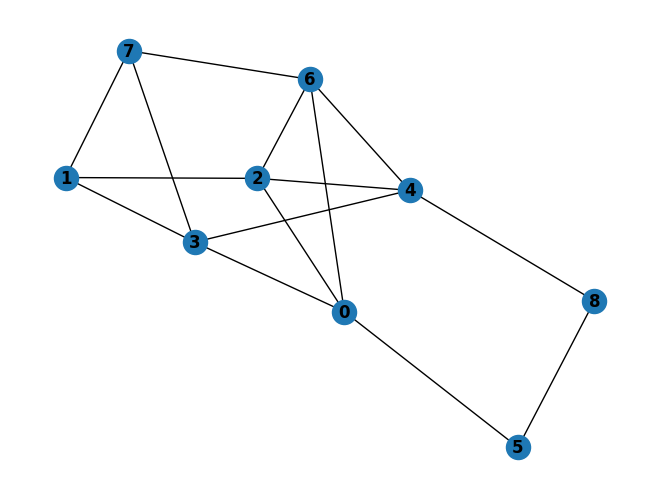

In [12]:
nx.draw(G, with_labels=True, font_weight='bold')

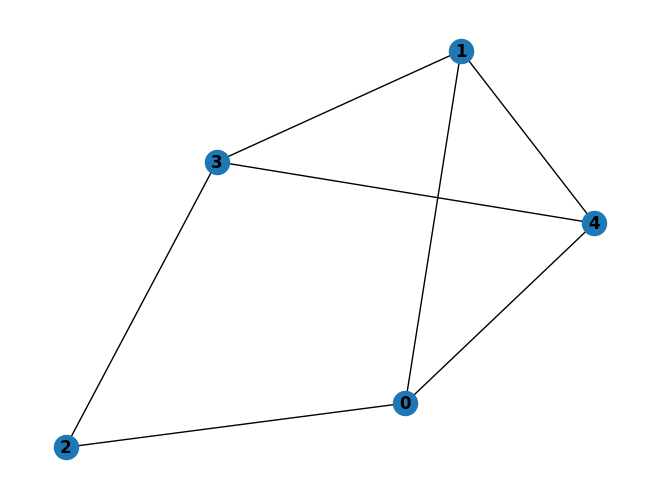

In [13]:
nx.draw(theta(G), with_labels=True, font_weight='bold')

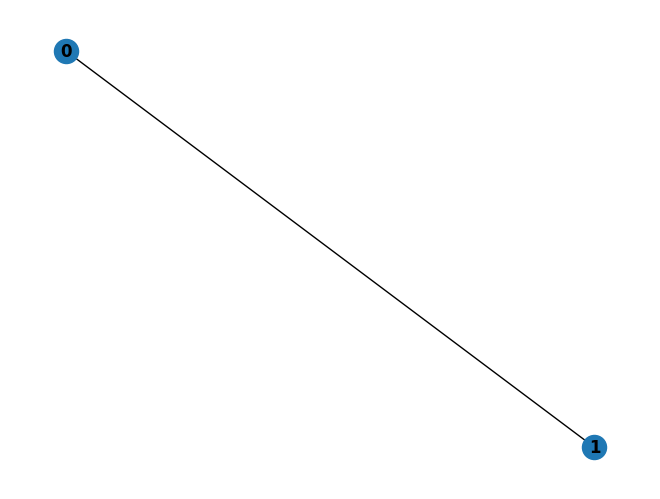

In [14]:
nx.draw(supp_graph(G,6), with_labels=True, font_weight='bold')

In [15]:
H=nx.Graph()
H.add_nodes_from(range(9))
H.add_edges_from([(0, 3), (0, 5), (0, 7), (0, 8), (1, 2), (1, 5), (2, 3), (3, 6), (3, 7), (3, 8), (4, 5), (4, 6), (4, 7), (4, 8), (5, 6), (5, 8), (6, 7)])

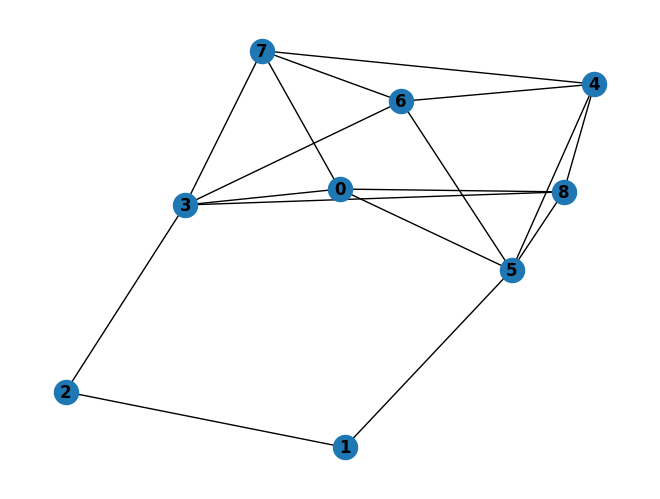

In [16]:
nx.draw(H, with_labels=True, font_weight='bold')

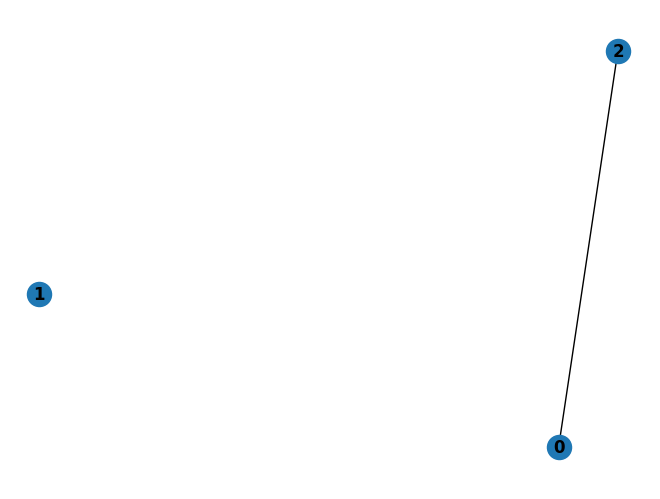

In [17]:
nx.draw(theta(H), with_labels=True, font_weight='bold')

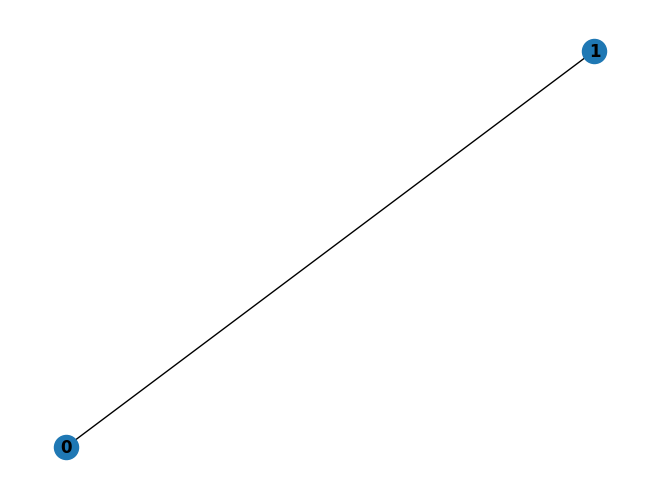

In [18]:
nx.draw(supp_graph(H,6), with_labels=True, font_weight='bold')